# Project scope

Exploratory analysis notebook leveraging seaborn, matplotlib, pandas and scikit-learn to develop skills in cleaning and visualizing text data. It is meant to replicate the necessary pre-processing steps to clean text data and transform it so it can be used for classification algorithms (i.e. sentiment analysis, topic modelling). Thus, the notebook is also leveraging some text feature extraction functions from scikit-learn to perform tasks like: dealing with punctuation and special characters, tokenization, stemming and vectorization using count vectorizer and tf-idf.

# Data source

The data used in this project can be found on Kaggle and it includes tweets from February 2015 made on US airlines. You can read more about the data using the following link: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

# Code

## Exploratory Analysis

In [1]:
# Libraries to import

import numpy as np 
import pandas as pd
import os
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
from nltk.stem.porter import *
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

pd.options.mode.chained_assignment = None

%matplotlib inline

# Read file
Airline_Tweets = pd.read_csv('../input/Tweets.csv')

In [2]:
# Check first 5 rows

Airline_Tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Count tweets

print(len(Airline_Tweets))

14640


In [4]:
# Use lambda expression to check null values for all variables

Airline_Tweets.apply(lambda x: sum(x.isnull()),axis=0)

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [5]:
# Print the first 10 tweets and numerate them with enumerate

tweets = list(Airline_Tweets['text'])

for message_no, tweets in enumerate(tweets[:10]):
    print(message_no, tweets)
    print('\n')

0 @VirginAmerica What @dhepburn said.


1 @VirginAmerica plus you've added commercials to the experience... tacky.


2 @VirginAmerica I didn't today... Must mean I need to take another trip!


3 @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse


4 @VirginAmerica and it's a really big bad thing about it


5 @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


6 @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


7 @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP


8 @virginamerica Well, I didn't…but NOW I DO! :-D


9 @VirginAmerica it was amazing, and arrived an hour early. You're too good to me.




In [6]:
# Use group by to describe variables by airline sentiment label - could give some indication of what distinguishes each label

Airline_Tweets.groupby('airline_sentiment').mean()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
airline_sentiment,,,,
negative,5.692602e+17,0.933365,0.731769,0.093375
neutral,5.691841e+17,0.823303,0.000000,0.060987
positive,5.691006e+17,0.872039,0.000000,0.069403


* If airline_sentiment_confidence and negativereason_confidence refer to likelyhood of the label being correct it seems both variables present good probability average values <br>
* Low average retweet rate, across all 3 sentiments

In [7]:
# Create a column with the lenght of each tweet

Airline_Tweets['length'] = Airline_Tweets['text'].apply(len)

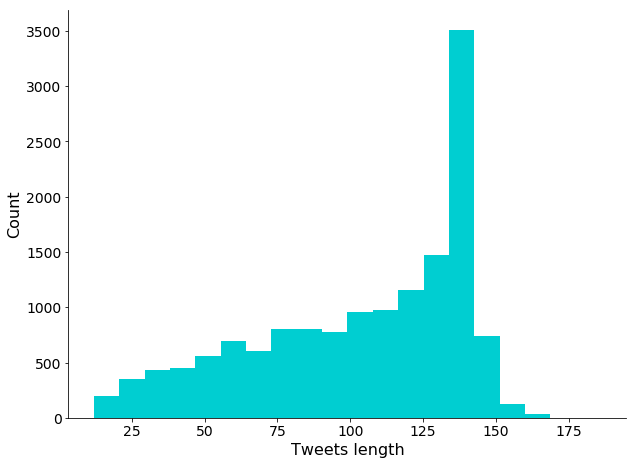

In [8]:
# Visualize tweets length

plt.figure(figsize=(10, 7.5))
# Remove the plot frame lines
ax1 = plt.subplot(111)  
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)  
# Get axis only on the bottom and left of the plot
ax1.get_xaxis().tick_bottom()  
ax1.get_yaxis().tick_left() 
# Format xticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Format labels
plt.xlabel("Tweets length", fontsize=16)  
plt.ylabel("Count", fontsize=16)
# Plot histogram with Tweets lenght
plt.hist(list(Airline_Tweets['length'].values),  color="darkturquoise", bins=20)
# Change background colour to white
ax1 = plt.gca()
ax1.set_facecolor('w')

plt.show()

* Distribution is slightly left skewed with mean tweet length (103) < median (114) <br>
* Spike in tweets around the 140 mark which used to be the maximum length for each tweet at the time (increased to 180 recently)

In [9]:
# By running the describe method in tweets length was able to check the longest tweet is 186 characters

# Use conditional selection and iloc to have a look at it
Airline_Tweets[Airline_Tweets['length'] == 186]['text'].iloc[0]

"@USAirways Eyyyy! Cancelled Flightlations, Flight Booking Problemss, reFlight Booking Problemss, but y'all got me on the same flight out tonight (not tomorrow) &amp; the FC upgrade. Thx!"

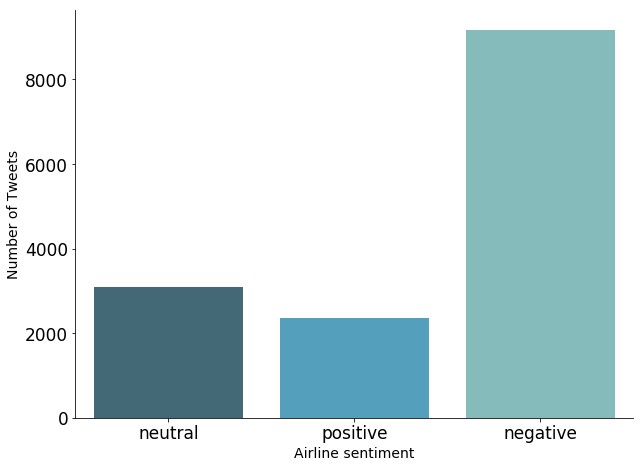

In [10]:
# Create a count plot with seaborn to understand how many ocurrences we have for each airline sentiment

plt.figure(figsize=(10, 7.5))
sentiment_ocurrences = sns.countplot(x='airline_sentiment', data=Airline_Tweets, palette='GnBu_d')
# Remove top and right axes
sns.despine()
# Set background colour
sns.set_style(style='white')

sentiment_ocurrences.set_xlabel("Airline sentiment",fontsize=14)
sentiment_ocurrences.set_ylabel("Number of Tweets",fontsize=14)
sentiment_ocurrences.tick_params(labelsize=17)

* More negative tweets than neutral or positive - something to have in mind for any machine learning tasks

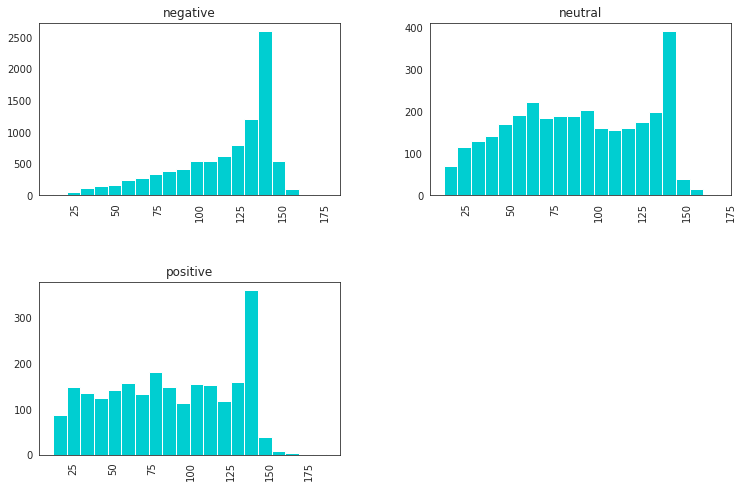

In [11]:
# Check if length is a distinguishing feature between a positive, neutral or negative tweet

Airline_Tweets.hist(column='length', by='airline_sentiment', color="darkturquoise", bins=20, figsize=(12,8))

# Change axes and tick labels font size
params = {'axes.titlesize':'12',
          'xtick.labelsize':'12',
          'ytick.labelsize':'12'}
plt.rcParams.update(params)

plt.show()

* Negative tweets seem to be left skewed <br>
* Positive and neutral tweets do not seem to show much of a trend. There is a spike around the 140 mark, but they seem to have a more uniform trend

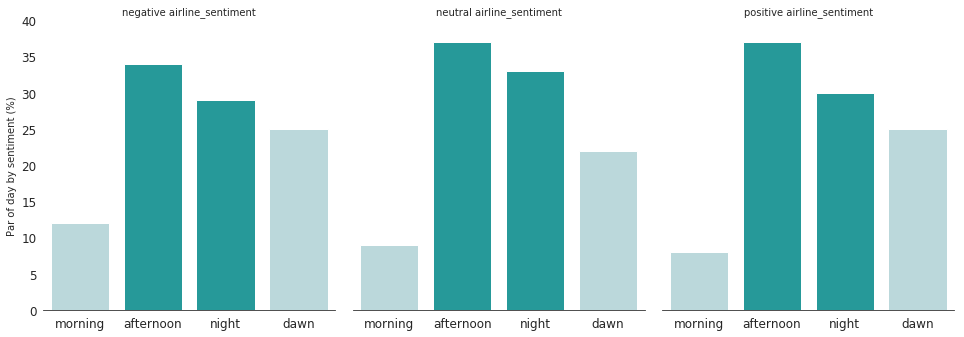

In [12]:
# Use datetime to convert tweet_created to datetime
Airline_Tweets['tweet_created'] = pd.to_datetime(Airline_Tweets['tweet_created'])
# Extract hour from tweet_created
Airline_Tweets['tweet_hour'] = Airline_Tweets['tweet_created'].dt.hour
# Define a series of conditions to get part of the day based on the hour
conditions = [
    (Airline_Tweets['tweet_hour'] >= 5) & (Airline_Tweets['tweet_hour'] <= 11),
    (Airline_Tweets['tweet_hour'] >= 12) & (Airline_Tweets['tweet_hour'] <= 18),
    (Airline_Tweets['tweet_hour'] >= 19) & (Airline_Tweets['tweet_hour'] <= 24)]

choices = ['morning', 'afternoon', 'night']
# Create column for part of day
Airline_Tweets['part_of_day'] = np.select(conditions, choices, default='dawn')
# Create iterator to be able to count number of tweets
Airline_Tweets['count'] = 1
# Group part of day and airline sentiment to count all combinations of both
table = Airline_Tweets.groupby(['part_of_day', 'airline_sentiment'])['count'].sum()
# Convert into a dataframe
table = pd.DataFrame(table)
# Reset all indexes
table.reset_index(inplace=True)
# Calculate percentage values
table['Percentage'] = 0
table['Percentage'].loc[table['airline_sentiment'] == 'negative'] = table['count'] / 9178 # 9178 - total number negative tweets
table['Percentage'].loc[table['airline_sentiment'] == 'neutral'] = table['count'] / 3099 # 3099 - total number neutral tweets
table['Percentage'].loc[table['airline_sentiment'] == 'positive'] = table['count'] / 2363 # 2363 - total number positive tweets
table['Percentage'] = round(table['Percentage'] * 100,0) #round percentage
# Specify colour for each group
day_part_colour = {"morning": "powderblue", "afternoon": "c", "night":"c", "dawn":"powderblue"}
# Use catplot from seaborn to plot the results from group by
ax = sns.catplot(x="part_of_day", y="Percentage", col="airline_sentiment",data=table, saturation=.6, kind="bar", ci=None, aspect=.9, palette=day_part_colour, order=['morning', 'afternoon', 'night', 'dawn'])
# Make some adjustments to plot default settings
(ax.set_axis_labels("", "Par of day by sentiment (%)")
  #.set_xticklabels(['morning', 'afternoon', 'night', 'dawn'])
  .set_titles("{col_name} {col_var}")
  .set(ylim=(0, 40))
  .despine(left=True))
# Change the font size
plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=14)

* Most people seem to have tweeted in the afternoon and night across all sentiment states - could related with frequency of flights at those times <br>
* **Note**: Part of day defined according with following time (debatable as it could change with geographic location):<br>
    * morning: 5am to 11am<br>
    * afternoon: 12pm to 6pm<br>
    * night: 6pm to midnight<br>
    * dawn: midnight to 5am

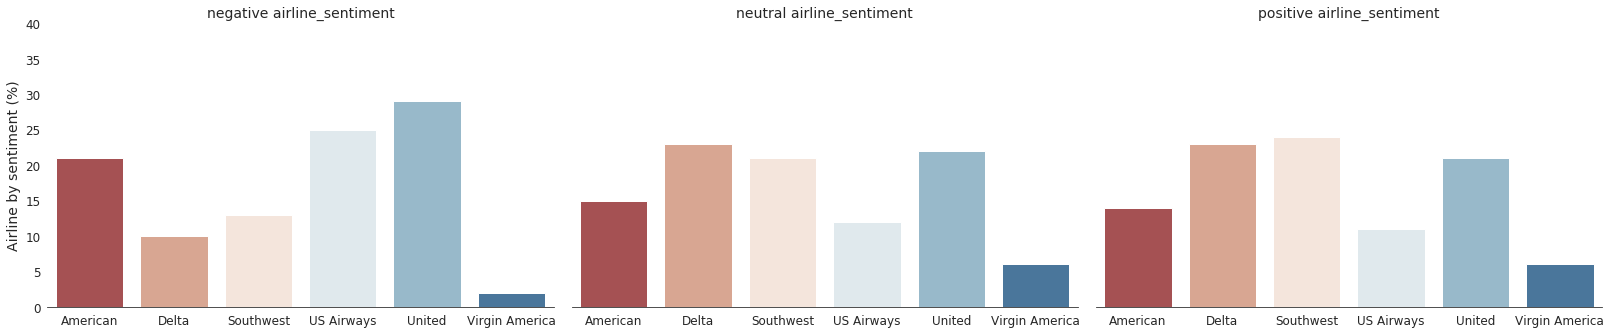

In [13]:
# Check airline sentiment for each airline

table = Airline_Tweets.groupby(['airline', 'airline_sentiment'])['count'].sum()
# Convert into a dataframe
table = pd.DataFrame(table)
# Reset all indexes
table.reset_index(inplace=True)
# Calculate percentage values
table['Percentage'] = 0
table['Percentage'].loc[table['airline_sentiment'] == 'negative'] = table['count'] / 9178 # 9178 - total number negative tweets
table['Percentage'].loc[table['airline_sentiment'] == 'neutral'] = table['count'] / 3099 # 3099 - total number neutral tweets
table['Percentage'].loc[table['airline_sentiment'] == 'positive'] = table['count'] / 2363 # 2363 - total number positive tweets
table['Percentage'] = round(table['Percentage'] * 100,0) #round percentage
# Use catplot from seaborn to plot the results from group by
ax = sns.catplot(x="airline", y="Percentage", col="airline_sentiment",data=table, saturation=.6, kind="bar", ci=None, aspect=1.5, palette='RdBu')
# Make some adjustments to plot default settings
(ax.set_axis_labels("", "Airline by sentiment (%)")
  .set_titles("{col_name} {col_var}")
  .set(ylim=(0, 40))
  .despine(left=True))
# Change the font size
plt.rcParams["axes.labelsize"] = 14
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=14)

* Delta, Southwest and Virgin America show good positive and neutral balance when compared to negative sentiment
* US Airways and United seem to gather most of the negative comments - overall more than 65% of their tweets are negative
* American and US Airways show bigger gaps between negative and positive or neutral sentiments

* **Note**: data is slightly inbalanced. Virgin America has only 504 tweets compared to US Airways and United with 2.9k and 3.8k, respectively

In [14]:
# Check the most common negative reason

Airline_Tweets['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

## Text pre-processing

* **Summary of pre-processing steps**: <br><br>
    * remove tweet handles from the original text column (e.g. @VirginAirlines)
    * remove special characters using [^a-zA-Z#]
    * remove short words
    * remove ponctuation signs using string.punctuation
    * remove stopwords using stopwords.words('english')
    * apply stemming by removing all the suffixes from words (e.g. 'cats', 'catlike', and 'catty' all should be the same as the string 'cat')
<br><br>
* The 5 rows printed after each step will allow one to sense check how the data is changing

In [15]:
# Create a new text column that removes tweet handles from text column (e.g. @VirginAirlines)

# Create standard function that will remove twitter handles
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt
# Apply the function above
Airline_Tweets['tidy_tweet'] = np.vectorize(remove_pattern)(Airline_Tweets['text'], "@[\w]*")
# Check first 5 messages
Airline_Tweets['tidy_tweet'].head()

0                                          What  said.
1     plus you've added commercials to the experien...
2     I didn't today... Must mean I need to take an...
3     it's really aggressive to blast obnoxious "en...
4             and it's a really big bad thing about it
Name: tidy_tweet, dtype: object

In [16]:
# Remove special characters

Airline_Tweets['tidy_tweet'] = Airline_Tweets['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
# Check first 5 messages
Airline_Tweets['tidy_tweet'].head()

0                                          What  said 
1     plus you ve added commercials to the experien...
2     I didn t today    Must mean I need to take an...
3     it s really aggressive to blast obnoxious  en...
4             and it s a really big bad thing about it
Name: tidy_tweet, dtype: object

In [17]:
# Remove words that are very short and might not have any meaning

Airline_Tweets['tidy_tweet'] = Airline_Tweets['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# Check first 5 messages
Airline_Tweets['tidy_tweet'].head()

0                                            What said
1              plus added commercials experience tacky
2          didn today Must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                   really thing about
Name: tidy_tweet, dtype: object

In [18]:
# Remove ponctuation sings and stop words

def text_process(mess):
    # Make use of string.punctuation to remove pontuation signs
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Use stopwords.words('english') to remove some of the most common words (e.g. 'the', 'of', 'a')
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Airline_Tweets['tidy_tweet'] = Airline_Tweets['tidy_tweet'].apply(text_process)
# Check first 5 messages
Airline_Tweets['tidy_tweet'].head()

0                                               [said]
1        [plus, added, commercials, experience, tacky]
2       [today, Must, mean, need, take, another, trip]
3    [really, aggressive, blast, obnoxious, enterta...
4                                      [really, thing]
Name: tidy_tweet, dtype: object

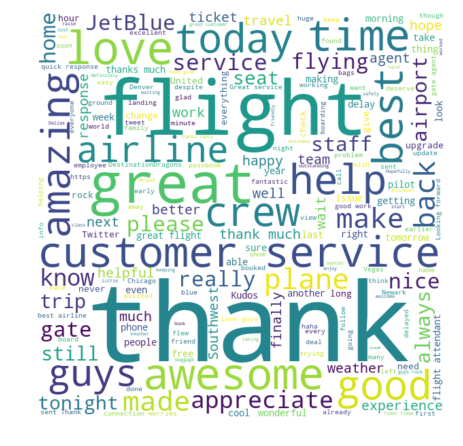

In [19]:
# Create a word cloud at this step to understand what are the most common words used in each tweet
# To speed up processing will split the data between positive and negative sentimet and plot a word cloud each

# Take only positive tweets

positive_tweets = Airline_Tweets.loc[Airline_Tweets['airline_sentiment'] == 'positive']['tidy_tweet']
# Reset the index
positive_tweets.reset_index(inplace=True, drop=True)
# Join each element in a list together
for i in range(len(positive_tweets)):
    positive_tweets[i] = ' '.join(positive_tweets[i])
# Join all the words in a single string
all_positive_words = ' '.join([text for text in positive_tweets])
# Create the wordcloud object
wordcloud = WordCloud(width=600, height=600, background_color="white").generate(all_positive_words)
# Plot graph
plt.figure(figsize=(10, 7.5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)

plt.show()

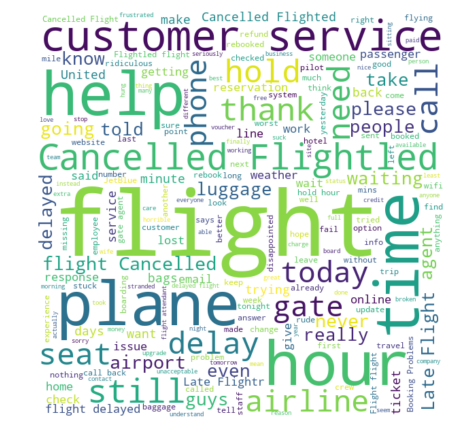

In [20]:
# Take only negative tweets

negative_tweets = Airline_Tweets.loc[Airline_Tweets['airline_sentiment'] == 'negative']['tidy_tweet']
# Reset the index
negative_tweets.reset_index(inplace=True, drop=True)
# Join each element in a list together
for i in range(len(negative_tweets)):
    negative_tweets[i] = ' '.join(negative_tweets[i])
# Join all the words in a single string
all_negative_words = ' '.join([text for text in negative_tweets])
# Create the wordcloud object
wordcloud = WordCloud(width=600, height=600, background_color="white").generate(all_negative_words)
# Plot graph
plt.figure(figsize=(10, 7.5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)

plt.show()

In [21]:
# Use PorterStemmer() method to apply stemming to all the tweets

stemmer = PorterStemmer()

Airline_Tweets['tidy_tweet'] = Airline_Tweets['tidy_tweet'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
# Check first 5 messages
Airline_Tweets['tidy_tweet'].head()

0                                               [said]
1                   [plu, ad, commerci, experi, tacki]
2         [today, must, mean, need, take, anoth, trip]
3    [realli, aggress, blast, obnoxi, entertain, gu...
4                                      [realli, thing]
Name: tidy_tweet, dtype: object

In [22]:
# Put back the column tidy_tweet on this original form with a string per row

clean_tweets = Airline_Tweets['tidy_tweet']

for i in range(len(clean_tweets)):
    clean_tweets[i] = ' '.join(clean_tweets[i])

Airline_Tweets['tidy_tweet'] = clean_tweets

Airline_Tweets['tidy_tweet'].head()

0                                                 said
1                         plu ad commerci experi tacki
2                 today must mean need take anoth trip
3    realli aggress blast obnoxi entertain guest fa...
4                                         realli thing
Name: tidy_tweet, dtype: object

## Vectorization

* **Steps covered in vectorization**: <br><br>
    * Use CountVectorizer to count the number of times each word occurs in every message following the [bag of words approach](https://en.wikipedia.org/wiki/Bag-of-words_model)
    * Use TF-IDF to apply weighting and normalization using the following formulas
        * TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
        * IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

In [23]:
# Use CountVectorizer object to create a matrix will all the words in every tweet

# For this analysis will use the default parameters for CountVectorizer
tweet_transformer = CountVectorizer().fit(Airline_Tweets['tidy_tweet'])

# Print total number of vocabulary words
print(len(tweet_transformer.vocabulary_))

8679


In [24]:
# Check an example in detail and take the 4th tweet in the dataset and see its vector representation
# For reference this is the text of the tweet: 'realli aggress blast obnoxi entertain guest face littl recours'

tweet_3 = Airline_Tweets['tidy_tweet'][3]

vector_3 = tweet_transformer.transform([tweet_3])
print(vector_3)
print(vector_3.shape)

# There are 9 unique words in this message and the second number (e.g. 124) will allow one to see what word that is

  (0, 124)	1
  (0, 762)	1
  (0, 2298)	1
  (0, 2469)	1
  (0, 3137)	1
  (0, 4285)	1
  (0, 5198)	1
  (0, 6057)	1
  (0, 6089)	1
(1, 8679)


In [25]:
# Apply the transformer in the entire tweets series

tweet_bag_of_words = tweet_transformer.transform(Airline_Tweets['tidy_tweet'])
# Check the shape and number of non-zero ocurrences
print('Shape of Matrix: ', tweet_bag_of_words.shape)
print('Amount of Non-Zero occurences: ', tweet_bag_of_words.nnz)

Shape of Matrix:  (14640, 8679)
Amount of Non-Zero occurences:  104652


In [26]:
# Adjust the weights with TF-IDF

# Each weight is calculated with the following formula:
# Scenario: in one document with 100 words the word 'data' appears 5 times. There are 1,000 ducoments to classify and the word 'data' appears 90 times in all of them
# TF = 5/100 = 0.05
# IDF = log(1,000/90) = 1
# Tf-idf weight = 0.05 * 1 = 0.05
from sklearn.feature_extraction.text import TfidfTransformer
# Apply the transformer to the bag of words
tweet_tfidf_transformer = TfidfTransformer().fit(tweet_bag_of_words)
tweet_tfidf = tweet_tfidf_transformer.transform(tweet_bag_of_words)
# Check the shape
print(tweet_tfidf.shape)

(14640, 8679)


In [27]:
# Add new column for airline sentiment with binary outcome: 1 for negative comment 0 for not negative

# Create dictionary to map
sentiment_dictionary = {'negative': 1, 'neutral': 0, 'positive': 0}
# Add new column mapping the dictionary
Airline_Tweets['airline_sentiment_model'] = Airline_Tweets['airline_sentiment'].map(sentiment_dictionary)

# Check first 5 rows
Airline_Tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,length,tweet_hour,part_of_day,count,tidy_tweet,airline_sentiment_model
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 19:35:52,NaN,Eastern Time (US & Canada),35,19,night,1,said,0
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 19:15:59,NaN,Pacific Time (US & Canada),72,19,night,1,plu ad commerci experi tacki,0
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 19:15:48,Lets Play,Central Time (US & Canada),71,19,night,1,today must mean need take anoth trip,0
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 19:15:36,NaN,Pacific Time (US & Canada),126,19,night,1,realli aggress blast obnoxi entertain guest fa...,1
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 19:14:45,NaN,Pacific Time (US & Canada),55,19,night,1,realli thing,1


The tidy_tweet and airline_sentiment_model columns showed above can be used in NLP tasks such as the following:

* Understand the difference between using a model only with CountVectorizer() excluding the TF-IDF step <br>
* Explore hyper parameter tunning in vectorization step and with MultiNomialNB algorithm <br>
* Test performance with different classification models <br>
* Extend analysis for longer period and check how seasonality affects negative airline sentiment